In [4]:
import pandas as pd
#Upload from computer
df = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn (1).csv")
print(df.head())

   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV StreamingMovies        Contract Pape

In [5]:
#start EDA
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

#set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10,6)
print("Libraries imported.")

Libraries imported.


In [27]:
#Dataset overview

print("=== DATASET OVERVIEW ===")
print(f"\nDataset shape: {df.shape}")
print(f"\nRows: {df.shape[0]}, Columns: {df.shape[1]}")
print("Column Information")
print(df.dtypes)

print("First 5 rows")
print(df.head())

print("Missing Values")
#print(df.isnull().sum())
#Total charges has missing values but shows 0. because : they are stored as empty strings. so they are not recognized as NaN by Pandas.
df['TotalCharges'].value_counts().head(10)
df['TotalCharges'] = df['TotalCharges'].replace(" ",None)
print(df.isnull().sum())

print("Statistical Summary")
print(df.describe())

print("Duplicate Rows")
print(f"Duplicates amount: {df.duplicated().sum()}")

#check for invalid category values
for col in df.select_dtypes(include='object'):
    print(f"\nUnique values in {col}:")
    print(df[col].unique())

#check numerical outliers
import numpy as np
for col in df.select_dtypes(include=np.number):
    print(f"\nOutliers in {col}:")
    Q1= df[col].quantile(0.25)
    Q3= df[col].quantile(0.75)
    IQR= Q1-Q3
    lower= Q1- 1.5*IQR
    upper= Q3+1.5*IQR
    print(df[(df[col]<lower) | (df[col] >upper)][col].head())


=== DATASET OVERVIEW ===

Dataset shape: (7043, 21)

Rows: 7043, Columns: 21
Column Information
customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
Churn                object
dtype: object
First 5 rows
   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No     

<Axes: xlabel='Churn', ylabel='count'>

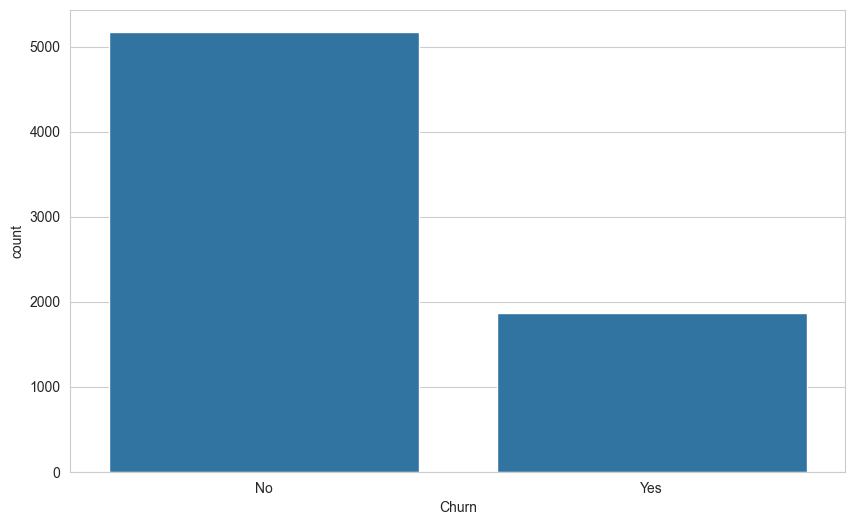

In [8]:
sns.countplot(x=df["Churn"], data=df)



In [9]:
cat_col =[]
num_col=[]
for cot in df.columns:
  if df[cot].dtype == "object":
    cat_col.append(cot)
  else:
    num_col.append(cot)

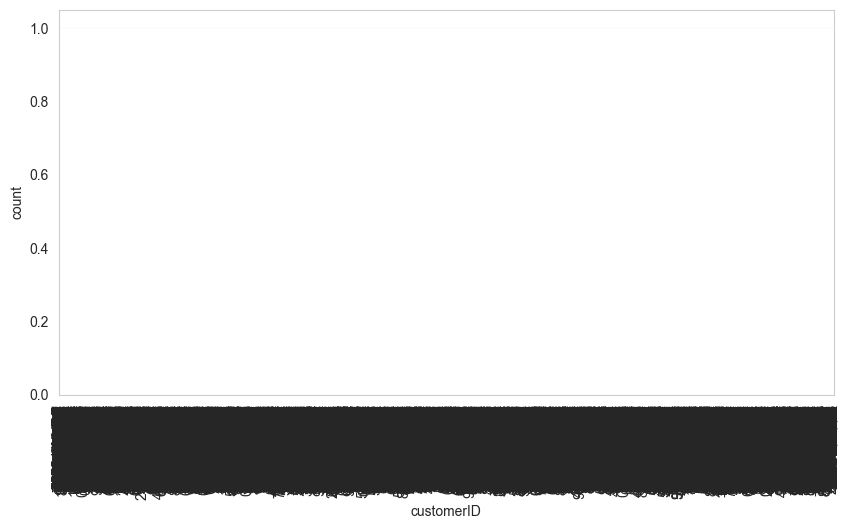

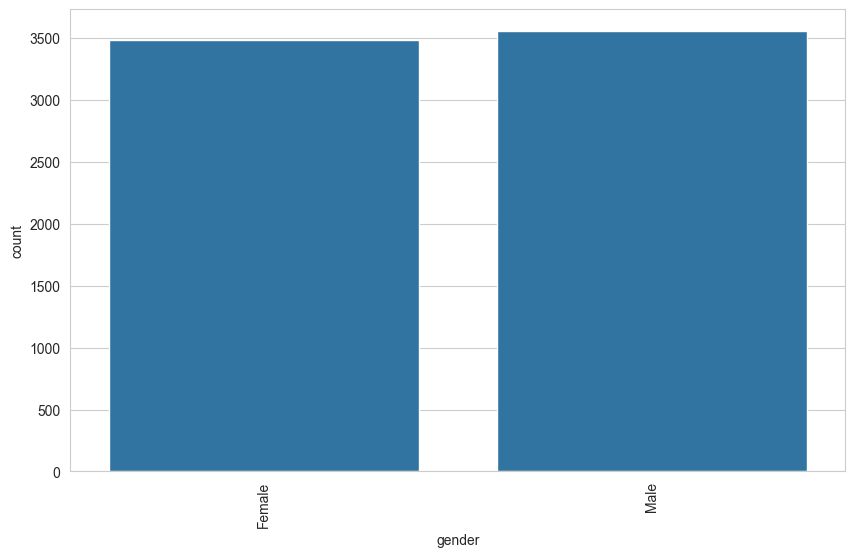

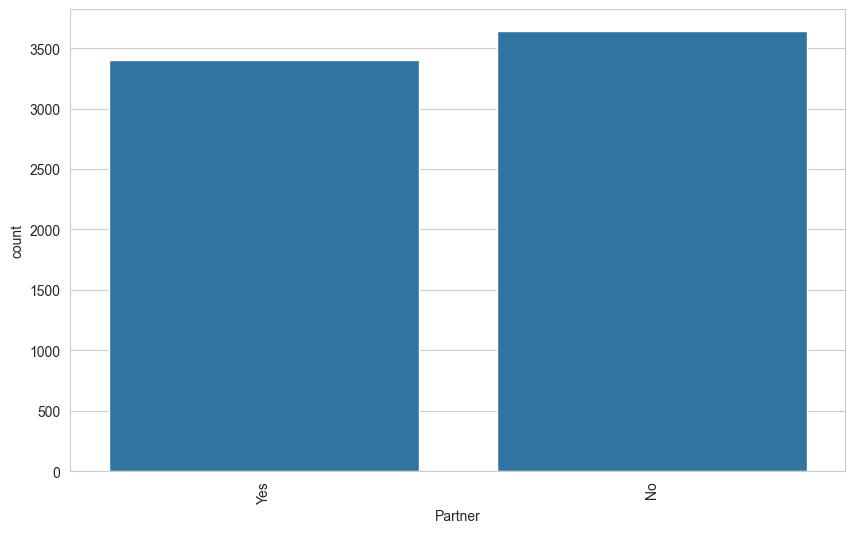

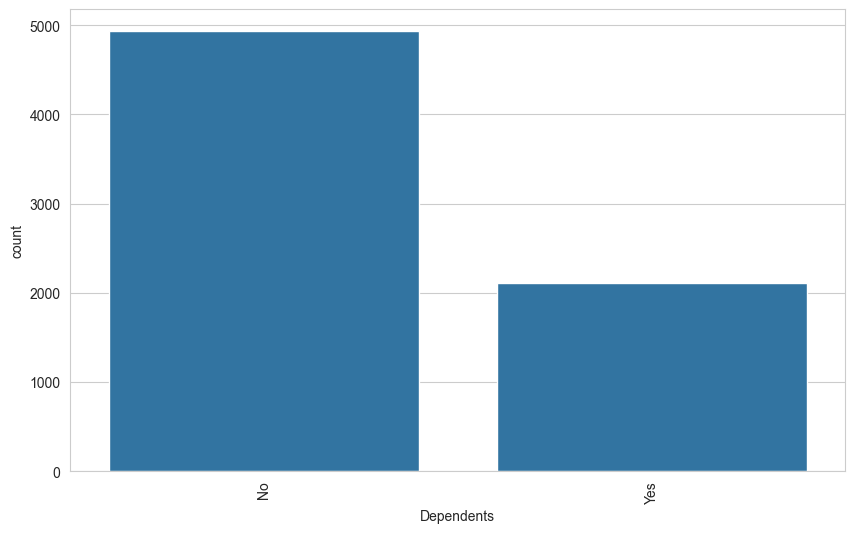

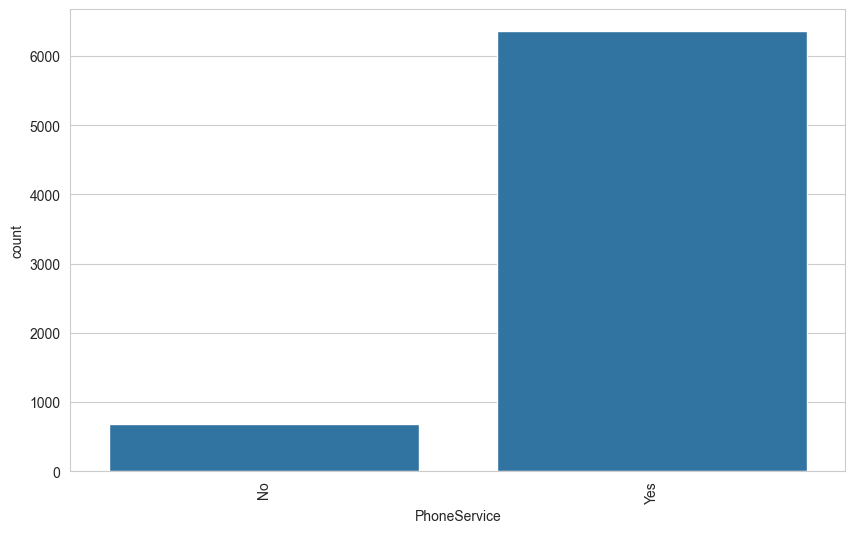

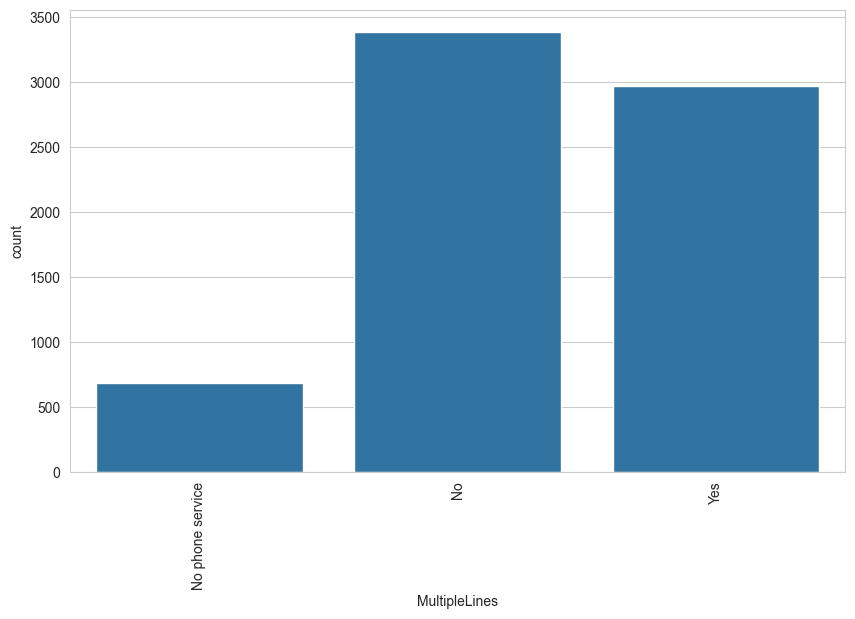

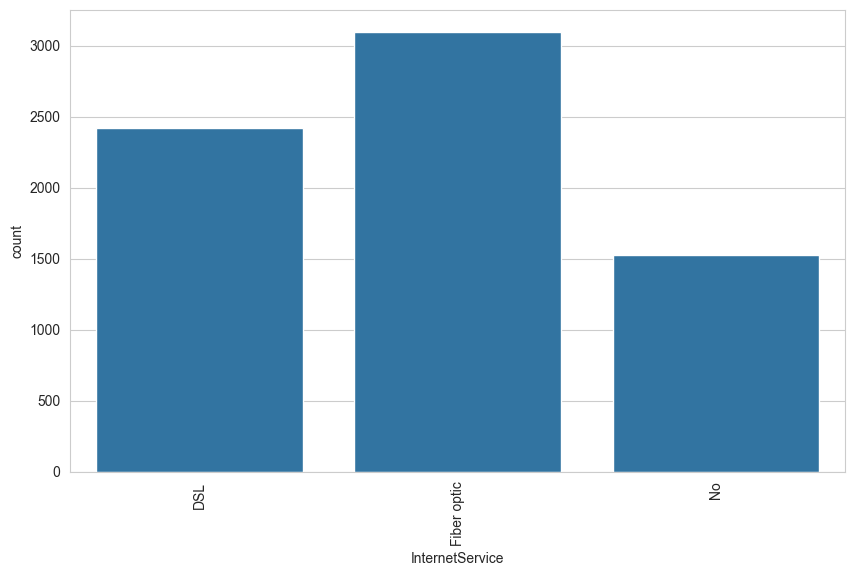

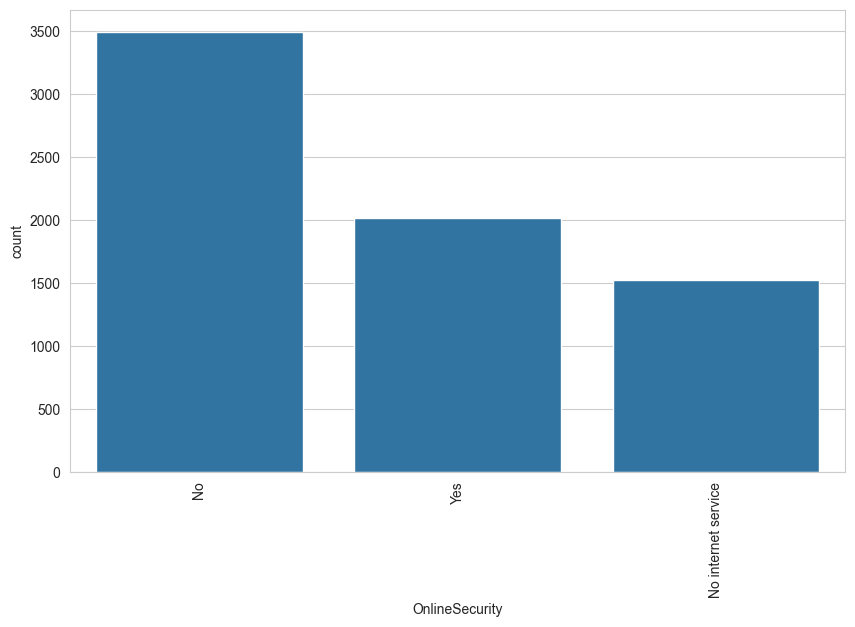

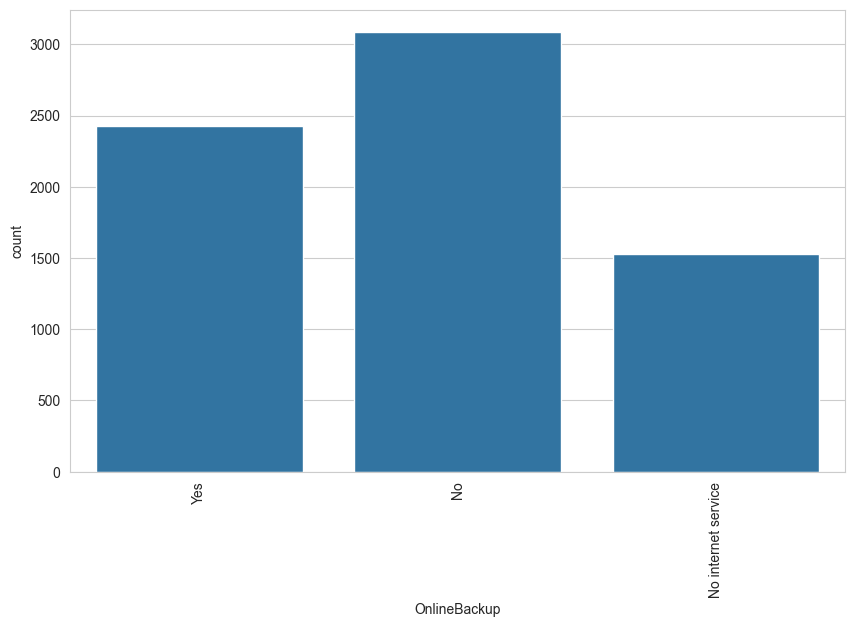

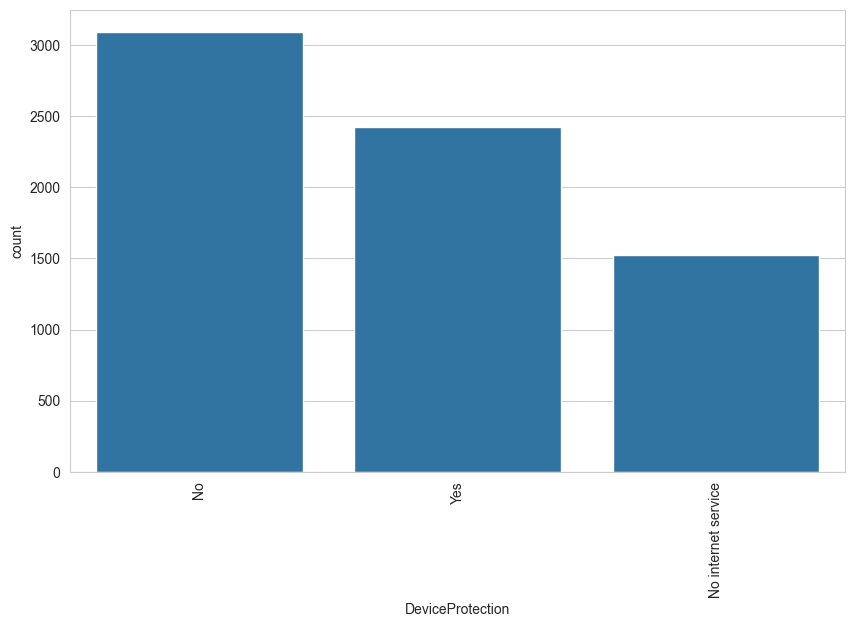

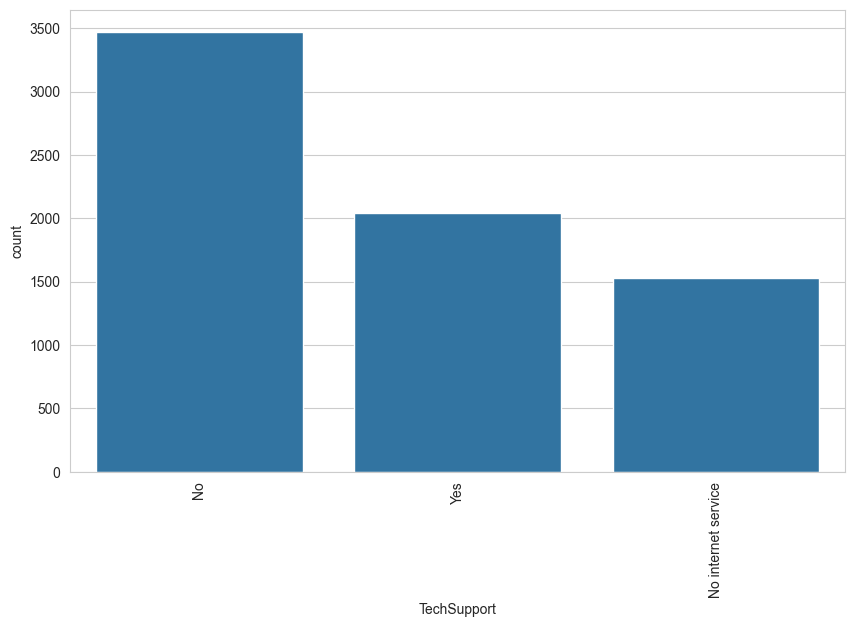

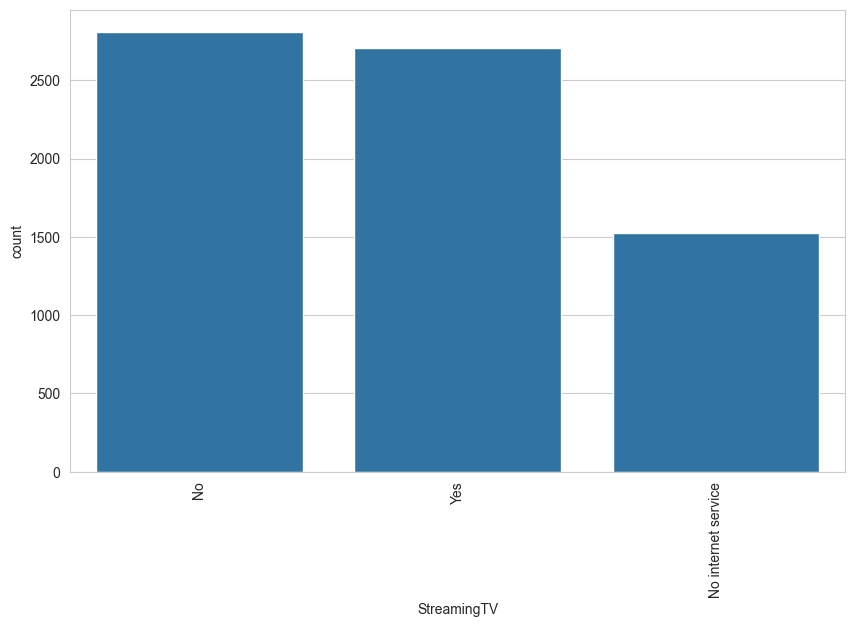

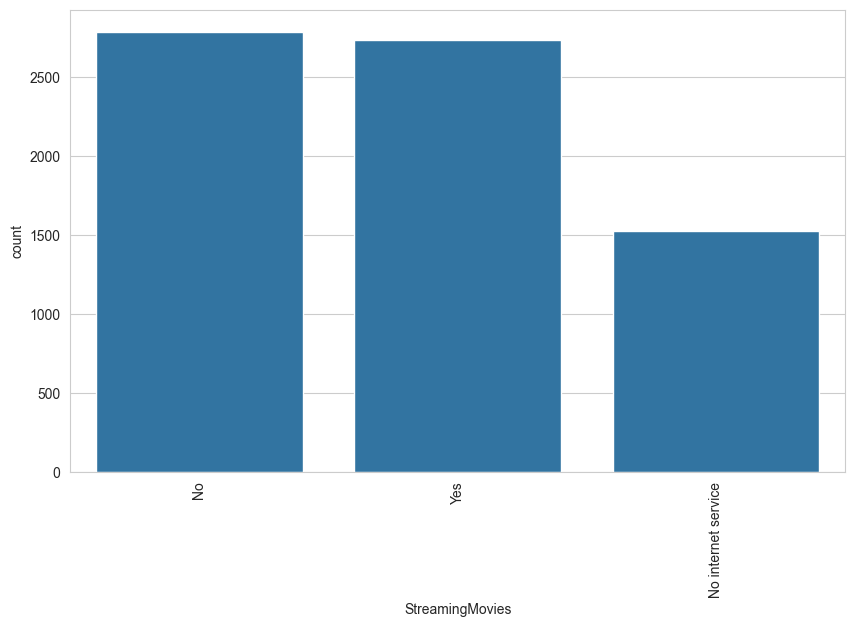

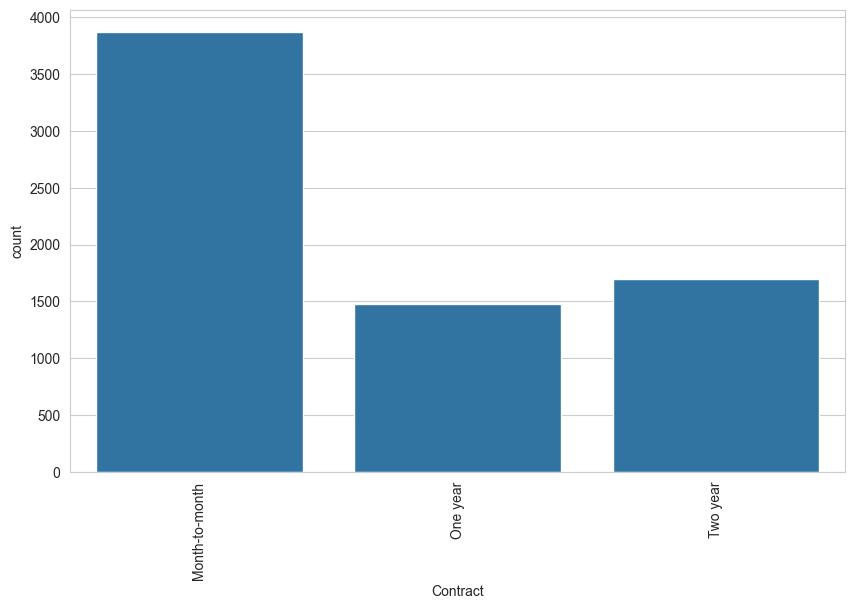

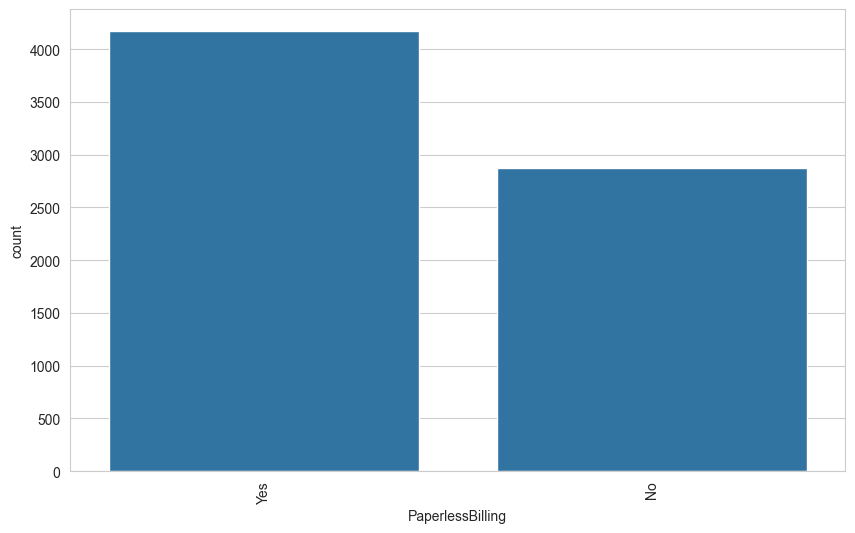

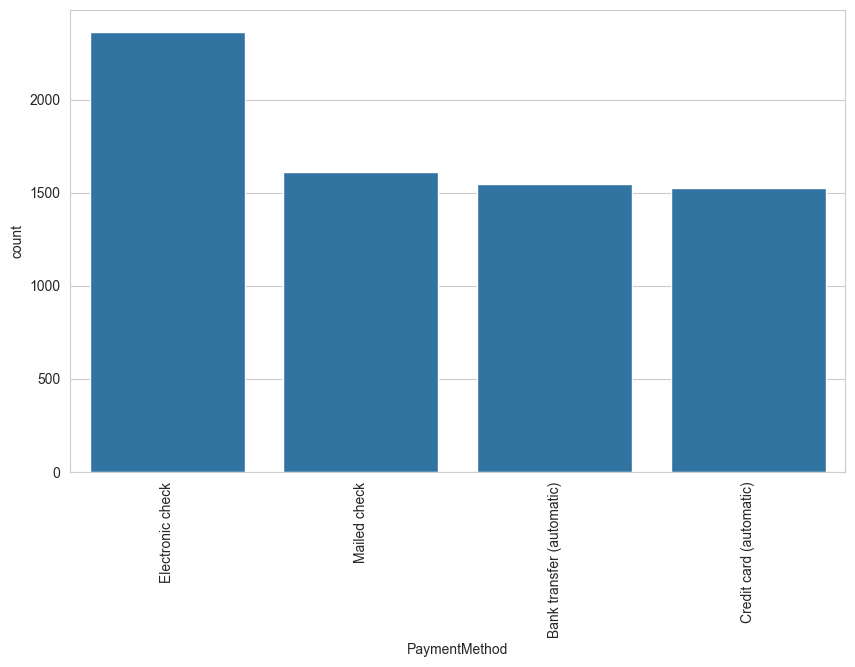

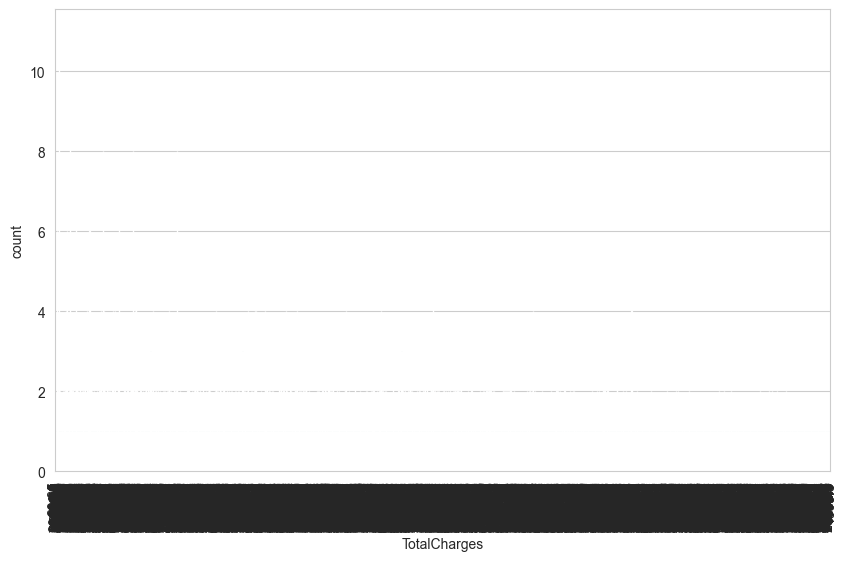

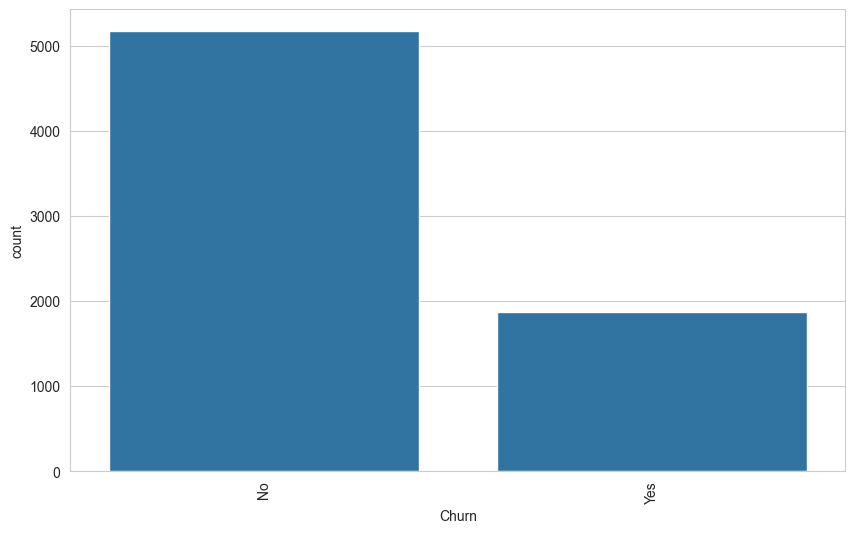

In [11]:
plt.subplots(figsize=(10,5))
for col in cat_col:
  sns.countplot(x=col, data=df)
  plt.xticks(rotation=90)
  plt.show()

In [12]:
df["TotalCharges"]=pd.to_numeric(df["TotalCharges"], errors='coerce')

In [13]:
df.TotalCharges.dtypes

dtype('float64')

In [14]:
df.TotalCharges.head()

0      29.85
1    1889.50
2     108.15
3    1840.75
4     151.65
Name: TotalCharges, dtype: float64

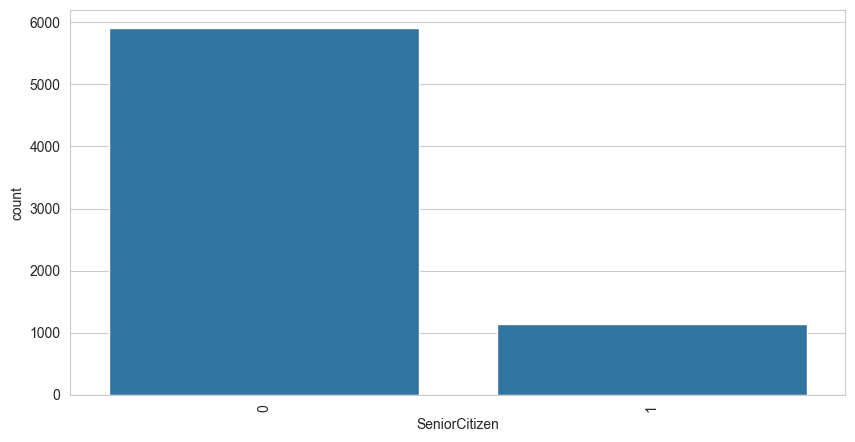

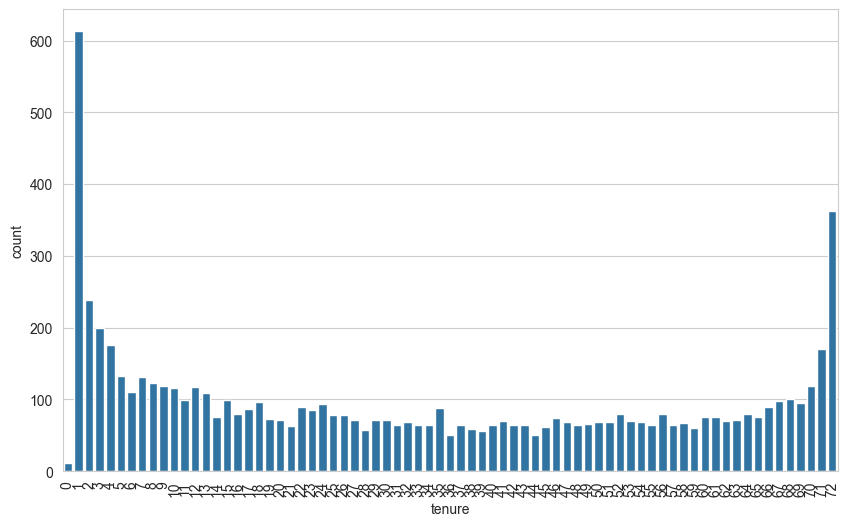

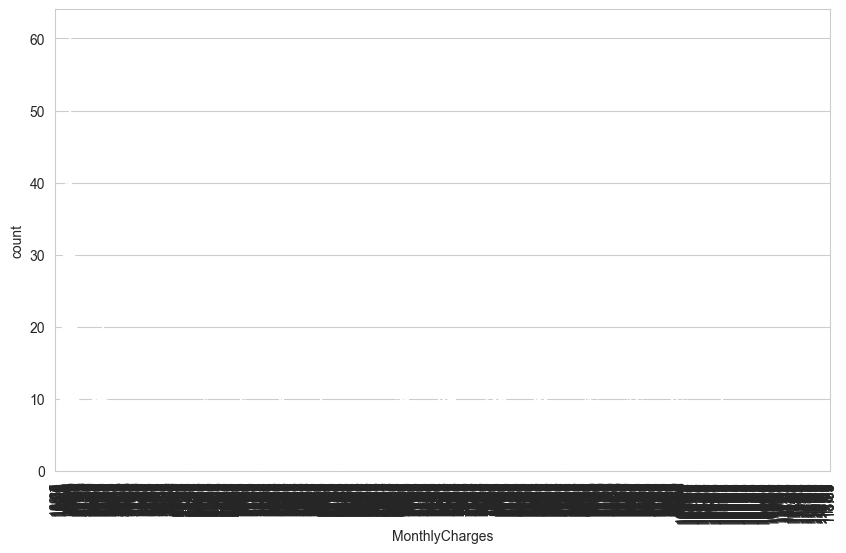

In [15]:
plt.subplots(figsize=(10,5))
for col in num_col:
  sns.countplot(x=col, data=df)
  plt.xticks(rotation=90)
  plt.show()

In [16]:
index = df[df.TotalCharges.isnull()].index


<Axes: xlabel='TotalCharges', ylabel='Count'>

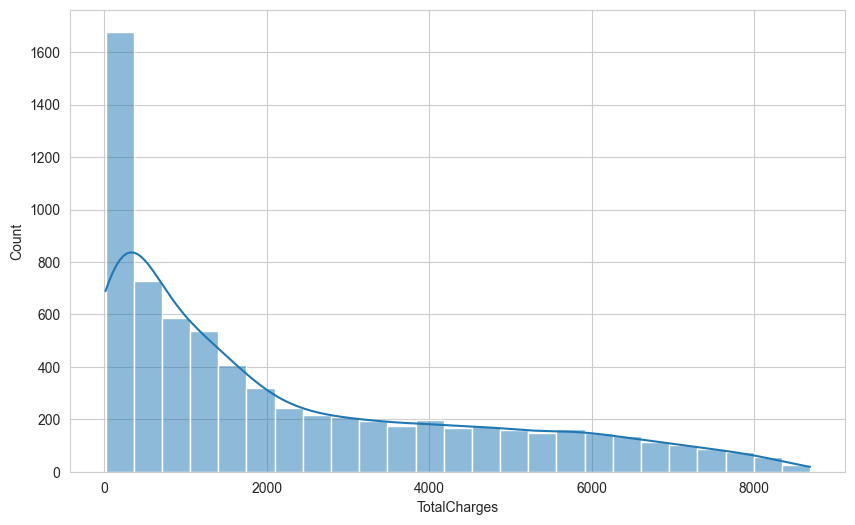

In [17]:
sns.histplot(x=df.TotalCharges , kde=True )

In [18]:
index

Index([488, 753, 936, 1082, 1340, 3331, 3826, 4380, 5218, 6670, 6754], dtype='int64')

In [19]:
df["TotalCharges"] = df["TotalCharges"].fillna(df["TotalCharges"].median())

In [20]:
df.TotalCharges.isnull().sum()

np.int64(0)

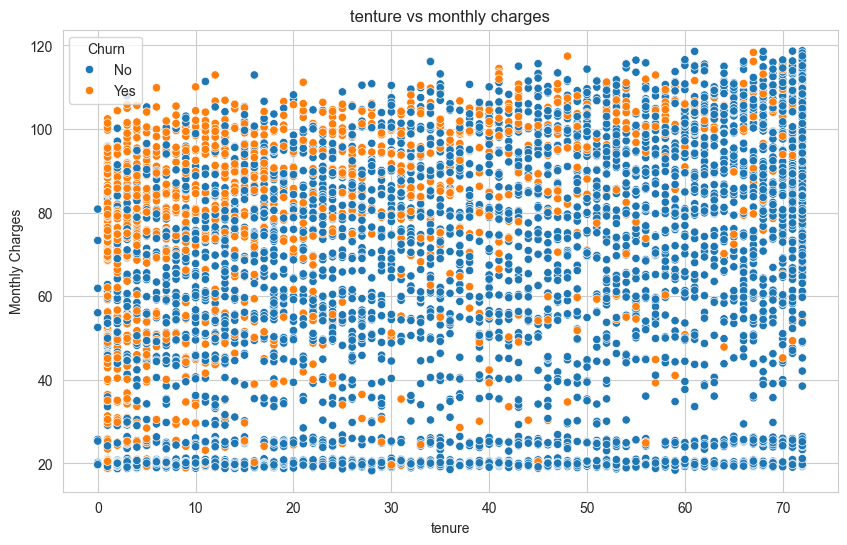

In [21]:
sns.scatterplot(x=df.tenure, y=df.MonthlyCharges, data=df , hue=df.Churn)
plt.title('tenture vs monthly charges')
plt.xlabel('tenure')
plt.ylabel('Monthly Charges')
plt.show()

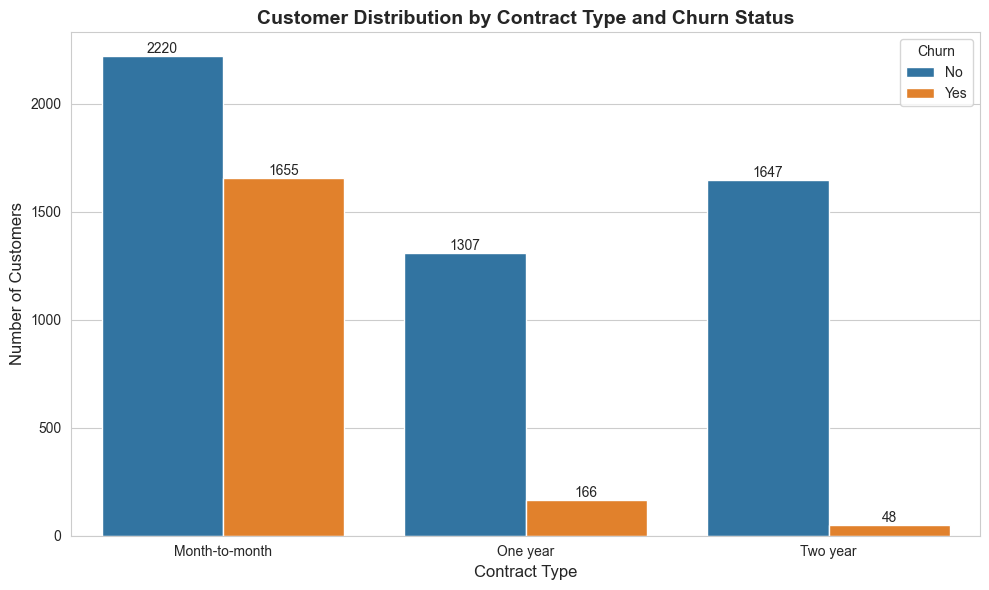

In [23]:
import os
os.makedirs('results/figures',exist_ok=True)
#count plot - contract type with churn breakdown
plt.figure(figsize=(10,6))
sns.countplot(x='Contract', hue= 'Churn', data=df)
plt.title('Customer Distribution by Contract Type and Churn Status',fontsize =14,fontweight ='bold')
plt.xlabel('Contract Type', fontsize=12)
plt.ylabel('Number of Customers', fontsize=12)
plt.legend(title='Churn', labels=['No', 'Yes'])
plt.xticks(rotation=0)
for container in plt.gca().containers:
    plt.gca().bar_label(container)

plt.tight_layout()
plt.savefig('results/figures/contract_vs_churn.png', dpi=300, bbox_inches='tight')
plt.show()

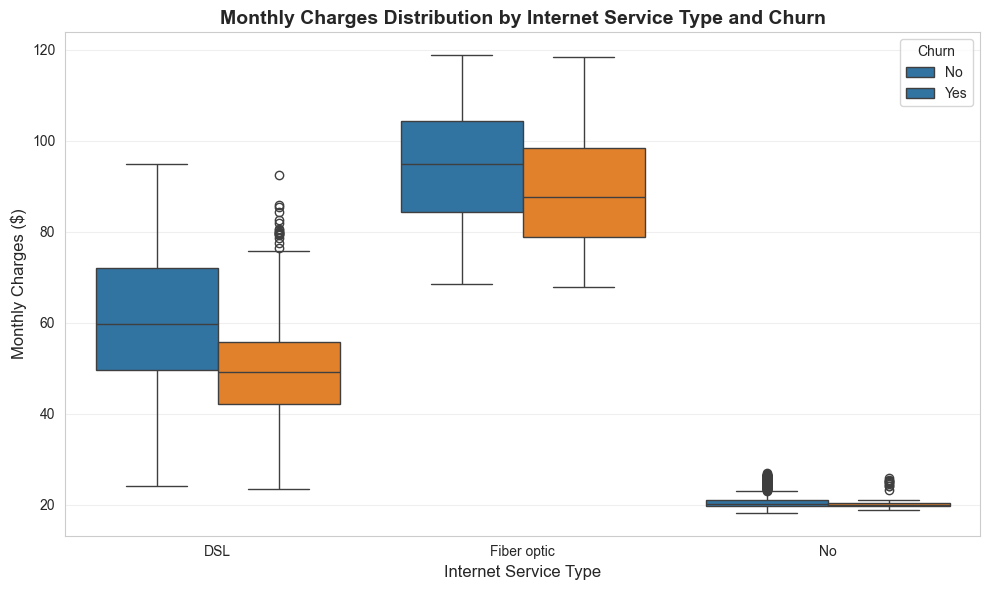

In [24]:
#Box plot - monthly charges by internet service type
plt.figure(figsize=(10,6))
sns.boxplot(x='InternetService', y='MonthlyCharges', hue='Churn', data=df)
plt.title('Monthly Charges Distribution by Internet Service Type and Churn',
          fontsize=14, fontweight='bold')
plt.xlabel('Internet Service Type', fontsize=12)
plt.ylabel('Monthly Charges ($)', fontsize=12)
plt.legend(title='Churn', labels=['No', 'Yes'])
plt.xticks(rotation=0)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('results/figures/internetservice_vs_monthlycharges.png', dpi=300, bbox_inches='tight')
plt.show()

<Figure size 1200x600 with 0 Axes>

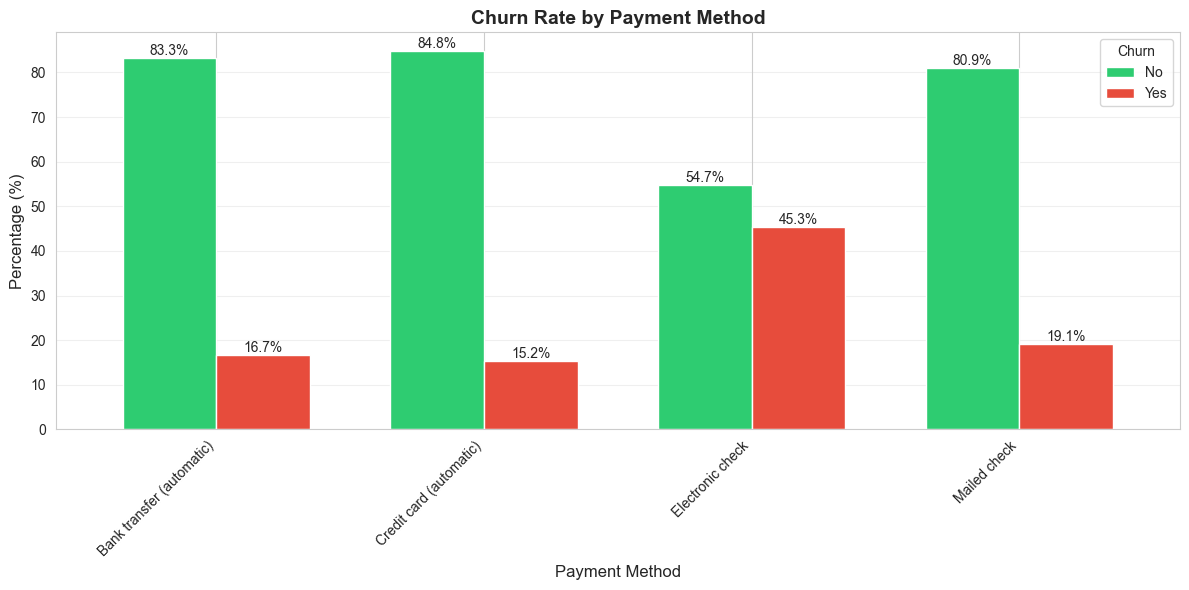

In [25]:
# Stacked bar chart: Payment Method vs Churn Rate
payment_churn = pd.crosstab(df['PaymentMethod'], df['Churn'], normalize='index') * 100

plt.figure(figsize=(12, 6))
payment_churn.plot(kind='bar', stacked=False, color=['#2ecc71', '#e74c3c'],
                   width=0.7, figsize=(12, 6))
plt.title('Churn Rate by Payment Method', fontsize=14, fontweight='bold')
plt.xlabel('Payment Method', fontsize=12)
plt.ylabel('Percentage (%)', fontsize=12)
plt.legend(title='Churn', labels=['No', 'Yes'])
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)

# Add percentage labels on bars
for container in plt.gca().containers:
    plt.gca().bar_label(container, fmt='%.1f%%')

plt.tight_layout()
plt.savefig('results/figures/payment_method_churn_rate.png', dpi=300, bbox_inches='tight')
plt.show()

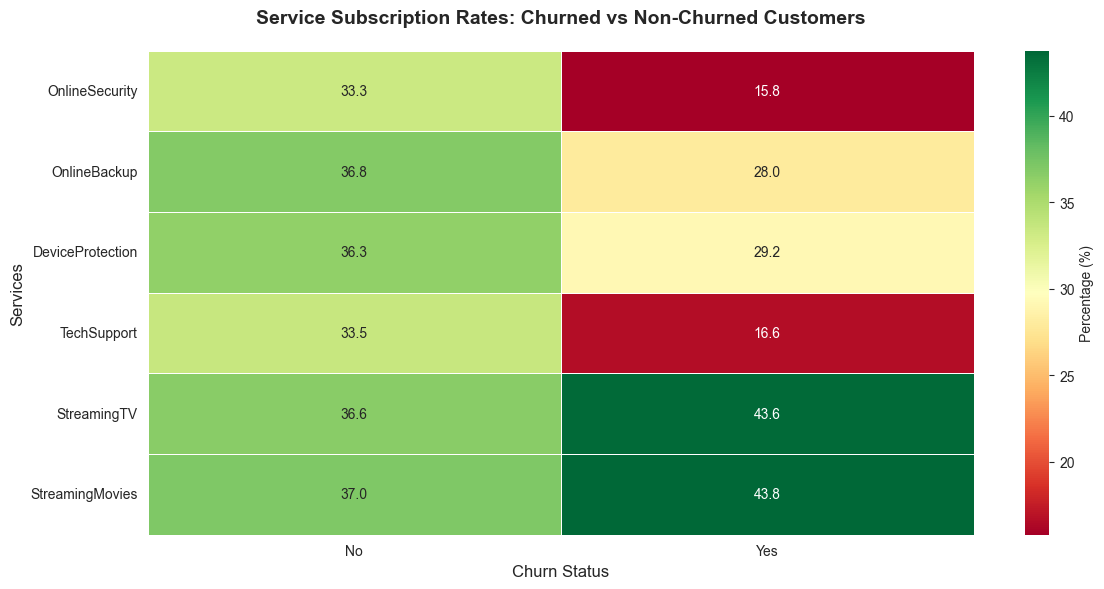

In [26]:
# Heatmap: Service subscriptions for churned vs non-churned customers
service_cols = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
                'TechSupport', 'StreamingTV', 'StreamingMovies']

# Create a summary dataframe
churn_services = df.groupby('Churn')[service_cols].apply(
    lambda x: (x == 'Yes').sum() / len(x) * 100
)

plt.figure(figsize=(12, 6))
sns.heatmap(churn_services.T, annot=True, fmt='.1f', cmap='RdYlGn',
            cbar_kws={'label': 'Percentage (%)'}, linewidths=0.5)
plt.title('Service Subscription Rates: Churned vs Non-Churned Customers',
          fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Churn Status', fontsize=12)
plt.ylabel('Services', fontsize=12)
plt.xticks([0.5, 1.5], ['No', 'Yes'], rotation=0)
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('results/figures/services_churn_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()